### Mike Ogrysko
### CS766 Information Retrieval and Natural Language Processing

Supervised Learning
- classification of abstracts of arxiv research papers
- Data from https://arxiv.org/category_taxonomy
- Classification with TfidfVectorizer with Pipeline
- Classification with POS processing with only nouns as tokens
- Top-20 bigrams from the POS processed tokens

In [1]:
from collections import defaultdict
from string import punctuation
%matplotlib inline
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics


In [2]:
#load train dataset
train = pd.read_json("arxiv_training.json", orient='records', lines=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329976 entries, 0 to 329975
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              329976 non-null  object
 1   submitter       329072 non-null  object
 2   authors         329976 non-null  object
 3   title           329976 non-null  object
 4   comments        217905 non-null  object
 5   journal-ref     61438 non-null   object
 6   doi             60322 non-null   object
 7   report-no       11599 non-null   object
 8   categories      329976 non-null  object
 9   license         293600 non-null  object
 10  abstract        329976 non-null  object
 11  versions        329976 non-null  object
 12  update_date     329976 non-null  object
 13  authors_parsed  329976 non-null  object
dtypes: object(14)
memory usage: 35.2+ MB


In [3]:
#load test dataset
test = pd.read_json("arxiv_testing.json", orient='records', lines=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329976 entries, 0 to 329975
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              329976 non-null  object
 1   submitter       329064 non-null  object
 2   authors         329976 non-null  object
 3   title           329976 non-null  object
 4   comments        217850 non-null  object
 5   journal-ref     61538 non-null   object
 6   doi             60313 non-null   object
 7   report-no       11695 non-null   object
 8   categories      329976 non-null  object
 9   license         293826 non-null  object
 10  abstract        329976 non-null  object
 11  versions        329976 non-null  object
 12  update_date     329976 non-null  object
 13  authors_parsed  329976 non-null  object
dtypes: object(14)
memory usage: 35.2+ MB


In [4]:
#function to give me a list of numerical categories
def cat_taxon(_df):
    my_cat_taxon_list = []
    for cat in _df.categories:
        first_cat = re.search(r'^([\w-]+)', cat.split(' ')[0]).group(1)
        if first_cat == 'cs':
            my_cat_taxon_list.append(0)
        elif first_cat == 'math':
            my_cat_taxon_list.append(1)
        elif first_cat == 'stat':
            my_cat_taxon_list.append(2)
        elif first_cat == 'econ':
            my_cat_taxon_list.append(3)
        elif first_cat == 'eess':
            my_cat_taxon_list.append(4)
        elif first_cat == 'astro-ph':
            my_cat_taxon_list.append(5)
        elif first_cat == 'cont-mat':
            my_cat_taxon_list.append(5)
        elif first_cat == 'gr-qc':
            my_cat_taxon_list.append(5)
        elif first_cat == 'hep-ex':
            my_cat_taxon_list.append(5)
        elif first_cat == 'hep-lat':
            my_cat_taxon_list.append(5)
        elif first_cat == 'hep-ph':
            my_cat_taxon_list.append(5)
        elif first_cat == 'hep-th':
            my_cat_taxon_list.append(5)
        elif first_cat == 'math-ph':
            my_cat_taxon_list.append(5)
        elif first_cat == 'nlin':
            my_cat_taxon_list.append(5)
        elif first_cat == 'nucl':
            my_cat_taxon_list.append(5)
        elif first_cat == 'physics':
            my_cat_taxon_list.append(5)
        elif first_cat == 'quant-ph':
            my_cat_taxon_list.append(5)
        elif first_cat == 'q-bio':
            my_cat_taxon_list.append(6)
        elif first_cat == 'q-fin':
            my_cat_taxon_list.append(7)
        else:
            my_cat_taxon_list.append(8)
    return my_cat_taxon_list


In [5]:
#get numerical categories for train and test datasets
train_cats = cat_taxon(train)
test_cats = cat_taxon(test)


In [6]:
#append numerical categories to dfs
train['NumCats'] = train_cats
test['NumCats'] = test_cats


In [7]:
#check counts full dataset
print(f'Training dataset: \n{train.NumCats.value_counts()}\n')
print(f'Testing dataset: \n{test.NumCats.value_counts()}')

Training dataset: 
1    181290
0    121694
2     14768
4      7285
8      4036
3       903
Name: NumCats, dtype: int64

Testing dataset: 
1    179867
0    123115
2     14718
4      7217
8      4167
3       892
Name: NumCats, dtype: int64


In [8]:
#drop rows with other cat
trainCats = train.loc[train['NumCats'] != 8]
testCats = test.loc[test['NumCats'] != 8]

In [9]:
#check dataset lengths and category counts
print(f'Train dataset length: {len(trainCats)}\n')
print(f'Training dataset NumCats: \n{trainCats.NumCats.value_counts()}\n')
print(f'Test dataset length: {len(testCats)}\n')
print(f'Testing dataset NumCats: \n{testCats.NumCats.value_counts()}')

Train dataset length: 325940

Training dataset NumCats: 
1    181290
0    121694
2     14768
4      7285
3       903
Name: NumCats, dtype: int64

Test dataset length: 325809

Testing dataset NumCats: 
1    179867
0    123115
2     14718
4      7217
3       892
Name: NumCats, dtype: int64


In [10]:
#reset indexes on the dataset
trainCats.reset_index(inplace = True)
testCats.reset_index(inplace = True)

**TfidfVectorizer with Pipeline**

In [11]:
#get categories
plCategoriesTr = np.unique(trainCats['NumCats'])
print(f'K categories={len(plCategoriesTr):d} {plCategoriesTr}')

K categories=5 [0 1 2 3 4]


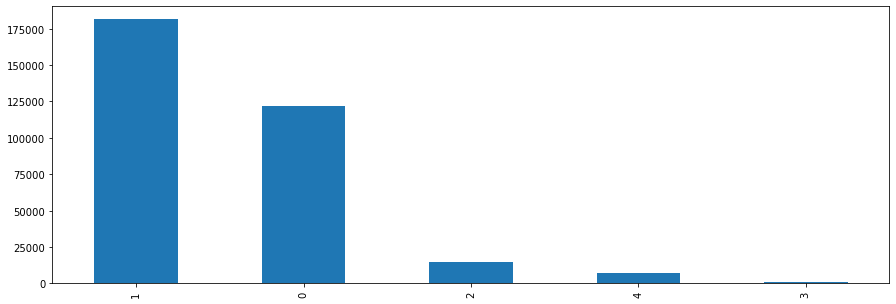

In [12]:
#plot training dataset categories
plt.figure(figsize=(15,5), dpi=72)
trainCats.NumCats.value_counts().plot(kind='bar');

In [13]:
#dict for cats
plCategoriesTr_mapping = {k:i for i, k in enumerate(plCategoriesTr)}
#convert to numerical np.array
yposts = np.array([plCategoriesTr_mapping[_] for _ in trainCats['NumCats']])

#check counts, size of the X dataset - raw features
X_tfidf = TfidfVectorizer().fit_transform(trainCats.abstract)
print(f'N data points= {X_tfidf.shape[0]}, M features= {X_tfidf.shape[1]}')

N data points= 325940, M features= 201442


In [14]:
N_FEATURES= 3000

#function to create pipeline
def make_pipeline(_clf, _mx_feats):
    return Pipeline([('vect', CountVectorizer(max_features=_mx_feats)), ('tfidf', TfidfTransformer()), ('clf', _clf)])

#svm, nb, and rf classifiers
svm_lin = make_pipeline(LinearSVC(class_weight='balanced', max_iter=10000), N_FEATURES)
nb = make_pipeline(MultinomialNB(), N_FEATURES)
rf = make_pipeline(RandomForestClassifier(n_jobs=8, n_estimators=300,
    max_depth=10, random_state=None, class_weight='balanced'), N_FEATURES)


In [15]:
#kfold eval function
def kfold_eval_docs(_clf, _Xdocs, _ydocs):
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(_Xdocs, _ydocs):
        _clf.fit(_Xdocs[train_index], _ydocs[train_index])
        y_pred = _clf.predict(_Xdocs[test_index])
        acc += [accuracy_score(_ydocs[test_index], y_pred)]

    return np.array(acc)

In [16]:
#nb on training dataset - abstract and NumCats
acc = kfold_eval_docs(nb, trainCats.abstract, trainCats.NumCats)
print(f'Naive Bayes CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')

Naive Bayes CV accuracy=0.873 0.001


In [17]:
#rf on training dataset - abstract and NumCats
acc = kfold_eval_docs(rf, trainCats.abstract, trainCats.NumCats)
print(f'Random Forest CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')

Random Forest CV accuracy=0.685 0.003


In [18]:
#svm on training dataset - abstract and NumCats
acc = kfold_eval_docs(svm_lin, trainCats.abstract, trainCats.NumCats)
print(f'Support Vector Machine CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')

Support Vector Machine CV accuracy=0.877 0.002


In [19]:
#function for eval - abstract and NumCats
def eval_docs2(_clf, _train, _test):
    X_train = _train.abstract
    y_train = _train.NumCats
    X_test = _test.abstract
    y_test = _test.NumCats
    _clf.fit(X_train, y_train)
    y_pred = _clf.predict(X_test)
    return y_test, y_pred

In [20]:
#function to get accuracy
def get_acc(_y_test, _y_pred):
    return ((np.sum(_y_test == _y_pred)).astype(float) / _y_test.shape[0])

In [21]:
#nb and confusion matrix on test data
y_test, y_pred = eval_docs2(nb, trainCats, testCats)
cm_nb = metrics.confusion_matrix(y_test,y_pred)
print(f"NB\nAccuracy= {get_acc(y_test,y_pred)*100:.2f}%\nConfusion Matrix\n{cm_nb}")

NB
Accuracy= 87.35%
Confusion Matrix
[[110168  11835    957      0    155]
 [  9498 167839   2521      0      9]
 [  7183   1105   6426      0      4]
 [   562     93    237      0      0]
 [  6832    180     52      0    153]]


In [22]:
#rf and confusion matrix on test data
y_test, y_pred = eval_docs2(rf, trainCats, testCats)
cm_rf = metrics.confusion_matrix(y_test,y_pred)
print(f"RF\nAccuracy= {get_acc(y_test,y_pred)*100:.2f}%\nConfusion Matrix\n{cm_rf}")

RF
Accuracy= 68.24%
Confusion Matrix
[[ 39649  27988  13439   2826  39213]
 [  3078 165970   5834   1090   3895]
 [  1046   1478  10521    436   1237]
 [    48    179    246    399     20]
 [   497    411    451     72   5786]]


In [23]:
#svm and confusion matrix on test data
y_test, y_pred = eval_docs2(svm_lin, trainCats, testCats)
cm_svm = metrics.confusion_matrix(y_test,y_pred)
print(f"SVM\nAccuracy= {get_acc(y_test,y_pred)*100:.2f}%\nConfusion Matrix\n{cm_svm}")

SVM
Accuracy= 87.64%
Confusion Matrix
[[102723   6904   5401    658   7429]
 [  5631 168100   4103    380   1653]
 [  2666    773  10575    302    402]
 [   183     78    239    385      7]
 [  2949    202    276     31   3759]]


**Classification with POS processing with only nouns as tokens**

In [24]:
#combination of stop words and punctuations, also get rid of br
stop_words = stopwords.words('english') + list(punctuation)
stop_words_set = set(stop_words) | set(['br', 'The', 'This'])

#develop tokenizer
def tokenize(text):
    terms = word_tokenize(text)
    #filter stop words
    terms = [w for w in terms if w not in stop_words_set and not w.isdigit()]
    #regex for contractions and other special character strings
    terms = [w for w in terms if not re.search(r'^\W+|\w\'\w+|\'\w+$', w)]
    terms = [w for w in terms if not re.search(r'^[^a-z]+$', w)]
    #regex for words two letters or less and numbers
    terms = [w for w in terms if not re.search(r'^\b\w{1,2}\b|(?<!\S)\d+(?!\S)$', w)]
    #lemmatize
    lemmatizer = WordNetLemmatizer()
    #was passing get_wordnet_pos() into lemmatizer but stopped because of memory issues
    #terms = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in terms]
    terms = [lemmatizer.lemmatize(w, 'n') for w in terms]
    return terms

In [25]:
#function to build string of words from abstract
def POS_list(_df, _pos):
    te_ab_list = []
    for ab in _df.abstract:
        #ab_list = []
        new_terms = ""
        terms = nltk.pos_tag(tokenize(ab))
        for term in terms:
            if _pos in term[1]:
                #ab_list.append(term[0])
                new_terms += term[0] + " "
        te_ab_list.append(new_terms)
    return te_ab_list


In [26]:
#get train NN words for each abstract
trainCats_POS = POS_list(trainCats, 'NN')


In [27]:
#get test NN words for each abstract
testCats_POS = POS_list(testCats, 'NN')


In [28]:
#add AbsPOS to train df
trainCatsDfPOS = trainCats.copy()
AbsPOS = pd.Series(trainCats_POS)
trainCatsDfPOS['AbsPOS'] = AbsPOS.values


In [29]:
#add AbsPOS to test df
testCatsDfPOS = testCats.copy()
AbsPOS = pd.Series(testCats_POS)
testCatsDfPOS['AbsPOS'] = testCats_POS


In [30]:
#sanity check on trainCatsDfPOS['AbsPOS']
trainCatsDfPOS['AbsPOS'][1]

'Regime process phenomenon model parameter fluctuate manner line finding study diffusion process Ornstein-Uhlenbeck type drift diffusion coefficient function Markov process distribution state space Exact time behavior regime drift Alongside time limit result form regime Finally application term Cox-Ingersoll-Ross diffusion model environment Exact time behavior term solution equation law '

In [31]:
#get the categories
plCategoriesTr3 = np.unique(trainCatsDfPOS['NumCats'])
print(f'K categories={len(plCategoriesTr3):d} {plCategoriesTr3}')


K categories=5 [0 1 2 3 4]


In [32]:
#dict for cats
plCategoriesTr_mapping3 = {k:i for i, k in enumerate(plCategoriesTr3)}
#convert to numerical np.array
yposts = np.array([plCategoriesTr_mapping3[_] for _ in trainCatsDfPOS['NumCats']])

#check counts, size of the X dataset - raw features
X_tfidf = TfidfVectorizer().fit_transform(trainCatsDfPOS.AbsPOS)
print(f'N data points= {X_tfidf.shape[0]}, M features= {X_tfidf.shape[1]}')

N data points= 325940, M features= 126537


In [33]:
#nb on train data
acc = kfold_eval_docs(nb, trainCatsDfPOS.AbsPOS, trainCatsDfPOS.NumCats)
print(f'Naive Bayes CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')

Naive Bayes CV accuracy=0.874 0.001


In [34]:
#rf on train data
acc = kfold_eval_docs(rf, trainCatsDfPOS.AbsPOS, trainCatsDfPOS.NumCats)
print(f'Random Forest CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')

Random Forest CV accuracy=0.683 0.003


In [35]:
#csm on train data
acc = kfold_eval_docs(svm_lin, trainCatsDfPOS.AbsPOS, trainCatsDfPOS.NumCats)
print(f'Support Vector Machine CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')

Support Vector Machine CV accuracy=0.867 0.001


In [36]:
#eval for AbsPOS and NumCats
def eval_docs3(_clf, _train, _test):
    X_train = _train.AbsPOS
    y_train = _train.NumCats
    X_test = _test.AbsPOS
    y_test = _test.NumCats
    _clf.fit(X_train, y_train)
    y_pred = _clf.predict(X_test)
    return y_test, y_pred

In [37]:
#nb and confusion matrix on test data
y_test, y_pred = eval_docs3(nb, trainCatsDfPOS, testCatsDfPOS)
cm_nb = metrics.confusion_matrix(y_test,y_pred)
print(f"NB\nAccuracy= {get_acc(y_test,y_pred)*100:.2f}%\nConfusion Matrix\n{cm_nb}")

NB
Accuracy= 87.36%
Confusion Matrix
[[110492  11316   1044      4    259]
 [  9807 167563   2475      1     21]
 [  6906   1476   6327      2      7]
 [   544     86    245     17      0]
 [  6693    248     56      0    220]]


In [38]:
#rf and confusion matrix on test data
y_test, y_pred = eval_docs3(rf, trainCatsDfPOS, testCatsDfPOS)
cm_rf = metrics.confusion_matrix(y_test,y_pred)
print(f"RF\nAccuracy= {get_acc(y_test,y_pred)*100:.2f}%\nConfusion Matrix\n{cm_rf}")

RF
Accuracy= 67.13%
Confusion Matrix
[[ 36299  29750  14837   3619  38610]
 [  2275 165915   6601   1375   3701]
 [   966   1626  10368    573   1185]
 [    31    137    219    494     11]
 [   427    526    542     90   5632]]


In [39]:
#svm and confusion matrix on test data
y_test, y_pred = eval_docs3(svm_lin, trainCatsDfPOS, testCatsDfPOS)
cm_svm = metrics.confusion_matrix(y_test,y_pred)
print(f"SVM\nAccuracy= {get_acc(y_test,y_pred)*100:.2f}%\nConfusion Matrix\n{cm_svm}")

SVM
Accuracy= 86.66%
Confusion Matrix
[[101233   7607   5845    903   7527]
 [  6130 166866   4488    617   1766]
 [  2800    938  10197    387    396]
 [   185     65    228    400     14]
 [  3048    234    277     23   3635]]


**Top-20 bigrams from the POS processed tokens**

In [40]:
#merge datasets and create new df
frames = [trainCatsDfPOS, testCatsDfPOS]
allDf = pd.concat(frames)


In [41]:
#check new df
allDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651749 entries, 0 to 325808
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           651749 non-null  int64 
 1   id              651749 non-null  object
 2   submitter       650658 non-null  object
 3   authors         651749 non-null  object
 4   title           651749 non-null  object
 5   comments        427774 non-null  object
 6   journal-ref     120782 non-null  object
 7   doi             117398 non-null  object
 8   report-no       21417 non-null   object
 9   categories      651749 non-null  object
 10  license         587394 non-null  object
 11  abstract        651749 non-null  object
 12  versions        651749 non-null  object
 13  update_date     651749 non-null  object
 14  authors_parsed  651749 non-null  object
 15  NumCats         651749 non-null  int64 
 16  AbsPOS          651749 non-null  object
dtypes: int64(2), object(15)
memor

In [42]:
#grab all of the years
yearList = []
for i in allDf.update_date:
    year = re.search(r'\d{4}', i)[0]
    yearList.append(int(year))

In [43]:
#create new year column in df
YearUp = pd.Series(yearList)
allDf['YearUp'] = YearUp.values
allDf.head()

,index,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,NumCats,AbsPOS,YearUp
0,0,math/0612766,Pablo Mira,"Jose A. Galvez, Antonio Martinez, Pablo Mira",The Bonnet problem for surfaces in homogeneous...,None,None,None,None,math.DG,None,We solve the Bonnet problem for surfaces in ...,"[{'version': 'v1', 'created': 'Tue, 26 Dec 200...",2007-05-23,"[[Galvez, Jose A., ], [Martinez, Antonio, ], [...",1,Bonnet problem surface isometry group surface ...,2007
1,1,1904.01474,Filip Lindskog,Filip Lindskog and Abhishek Pal Majumder,Exact long time behavior of some regime switch...,None,None,None,None,math.PR,http://arxiv.org/licenses/nonexclusive-distrib...,Regime switching processes have proved to be...,"[{'version': 'v1', 'created': 'Tue, 2 Apr 2019...",2019-04-03,"[[Lindskog, Filip, ], [Majumder, Abhishek Pal, ]]",1,Regime process phenomenon model parameter fluc...,2019
2,2,1712.04007,Joseph Haraldson,"Mark Giesbrecht, Joseph Haraldson, George Labahn",Computing Lower Rank Approximations of Matrix ...,31 Pages,None,None,None,cs.SC,http://arxiv.org/licenses/nonexclusive-distrib...,Given an input matrix polynomial whose coeff...,"[{'version': 'v1', 'created': 'Mon, 11 Dec 201...",2017-12-13,"[[Giesbrecht, Mark, ], [Haraldson, Joseph, ], ...",0,input coefficient point number problem matrix ...,2017
3,3,1208.4087,Alexander Baranov,Alexander Baranov,Classification of the direct limits of involut...,None,"J. Algebra 381 (2013), 73-95",10.1016/j.jalgebra.2013.02.004,None,math.RA,http://arxiv.org/licenses/nonexclusive-distrib...,A classification of (countable) direct limit...,"[{'version': 'v1', 'created': 'Mon, 20 Aug 201...",2013-03-04,"[[Baranov, Alexander, ]]",1,classification limit involution algebra field ...,2013
4,4,1410.4383,Jasper V. Stokman,Jasper V. Stokman,Connection problems for quantum affine KZ equa...,47 pages. v2: small corrections; v.3: small co...,"Comm. Math. Phys. 338 (2015), no. 3, 1363-1409",10.1007/s00220-015-2375-z,None,math.QA,http://arxiv.org/licenses/nonexclusive-distrib...,Cherednik attached to an affine Hecke algebr...,"[{'version': 'v1', 'created': 'Thu, 16 Oct 201...",2015-10-16,"[[Stokman, Jasper V., ]]",1,Cherednik Hecke algebra module system differen...,2015


In [44]:
#filter out only the entries from 2011 or later
allDf = allDf.loc[allDf['YearUp'] >= 2011]
allDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555626 entries, 1 to 325808
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           555626 non-null  int64 
 1   id              555626 non-null  object
 2   submitter       555126 non-null  object
 3   authors         555626 non-null  object
 4   title           555626 non-null  object
 5   comments        354848 non-null  object
 6   journal-ref     97091 non-null   object
 7   doi             107064 non-null  object
 8   report-no       13027 non-null   object
 9   categories      555626 non-null  object
 10  license         546667 non-null  object
 11  abstract        555626 non-null  object
 12  versions        555626 non-null  object
 13  update_date     555626 non-null  object
 14  authors_parsed  555626 non-null  object
 15  NumCats         555626 non-null  int64 
 16  AbsPOS          555626 non-null  object
 17  YearUp          555626 non-nu

In [45]:
#function to get bigrams
def grams_dict(_df, _n, _cat):
    grams_dict_counts = defaultdict(int)
    for i, r in _df.iterrows():
        if r.NumCats == _cat:
            terms = word_tokenize(r.AbsPOS)
            if len(terms) >= _n:
                for i in range(len(terms)-_n+1):
                    gram_li = [_ for _ in terms[i:i+_n]]
                    gram = ' '.join(gram_li)
                    grams_dict_counts[gram] += 1
    return grams_dict_counts

In [46]:
#get list of cats from df
getCats = np.unique(allDf['NumCats'])
print(getCats)

[0 1 2 3 4]


In [47]:
#build bigrams dicts for each cat
bigrams0 = grams_dict(allDf, 2, 0)
bigrams1 = grams_dict(allDf, 2, 1)
bigrams2 = grams_dict(allDf, 2, 2)
bigrams3 = grams_dict(allDf, 2, 3)
bigrams4 = grams_dict(allDf, 2, 4)


In [48]:
#sort the bigrams dicts
sort_grams0 = dict(sorted(bigrams0.items(), key=lambda kv:kv[1],reverse=True)[:20])
sort_grams1 = dict(sorted(bigrams1.items(), key=lambda kv:kv[1],reverse=True)[:20])
sort_grams2 = dict(sorted(bigrams2.items(), key=lambda kv:kv[1],reverse=True)[:20])
sort_grams3 = dict(sorted(bigrams3.items(), key=lambda kv:kv[1],reverse=True)[:20])
sort_grams4 = dict(sorted(bigrams4.items(), key=lambda kv:kv[1],reverse=True)[:20])

In [49]:
#convert dicts to lists and print results
sort_grams0_list = list(sort_grams0.items())
sort_grams1_list = list(sort_grams1.items())
sort_grams2_list = list(sort_grams2.items())
sort_grams3_list = list(sort_grams3.items())
sort_grams4_list = list(sort_grams4.items())

In [50]:
#print top 20 bigrams for each cat
#{0:'Computer Science', 1:'Mathematics', 2:'Statistics', 3:'Economics', 4:'EESS'}

print(f"\tCS\t\t\t\tMath\t\t\tStats")
for i in range(20):
    print(f"{sort_grams0_list[i][1]} {sort_grams0_list[i][0]:25s}{sort_grams1_list[i][1]} {sort_grams1_list[i][0]:25s}{sort_grams2_list[i][1]} {sort_grams2_list[i][0]:27s}")

print(f"\n\tEcon\t\t\t\tEESS")
for i in range(20):
    print(f"{sort_grams3_list[i][1]} {sort_grams3_list[i][0]:25s}{sort_grams4_list[i][1]} {sort_grams4_list[i][0]:25s}")
    


	CS				Math			Stats
12946 result show              10054 paper study              2983 Monte Carlo                
7590 paper propose            6097 solution equation        2362 time series                
6957 optimization problem     5850 existence solution       2322 simulation study           
5418 Experimental result      5061 optimization problem     1700 regression model           
5272 paper study              4967 Lie algebra              1441 model data                 
4772 training data            4874 group group              1402 model model                
4754 computer vision          4816 Lie group                1327 Markov chain               
4683 model model              4793 Banach space             1261 data analysis              
4451 state art                4647 Hilbert space            1124 model parameter            
4431 address problem          4134 paper show               1121 model selection            
4237 network model            4075 vector field 

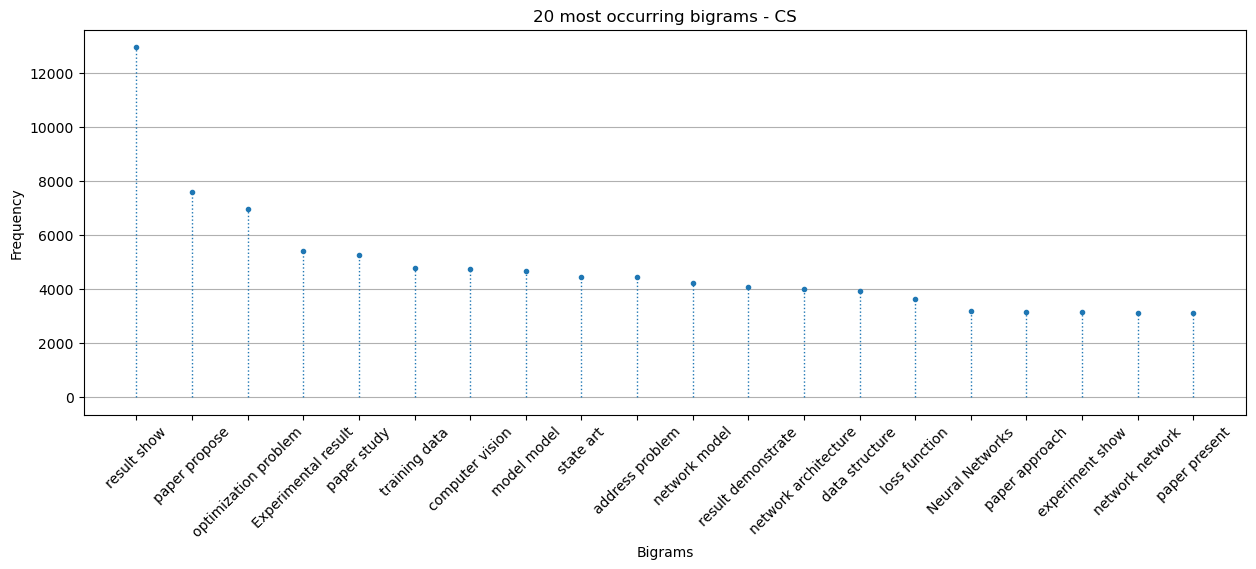

In [51]:
#plot the frequency cat 0
x, y = zip(*sort_grams0_list)

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(x, y, '.')
plt.xticks(rotation = 45)
ax.vlines(x, 0, y, lw=1, ls='dotted')
plt.title('20 most occurring bigrams - CS'); plt.xlabel('Bigrams'); plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()

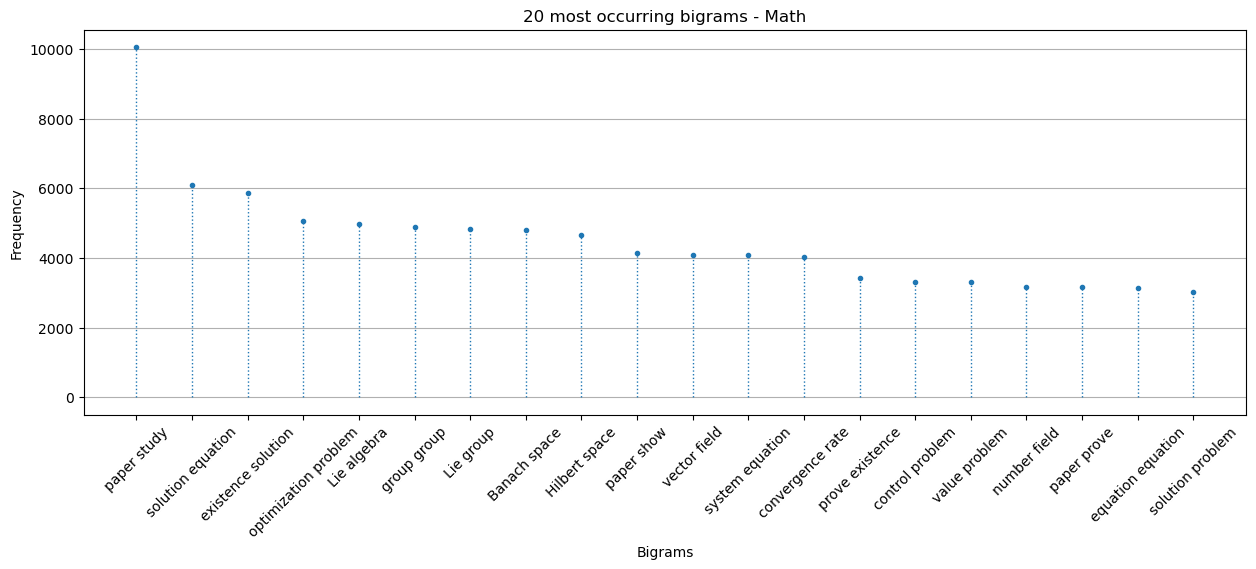

In [52]:
#plot the frequency cat 1
x, y = zip(*sort_grams1_list)

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(x, y, '.')
plt.xticks(rotation = 45)
ax.vlines(x, 0, y, lw=1, ls='dotted')
plt.title('20 most occurring bigrams - Math'); plt.xlabel('Bigrams'); plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()

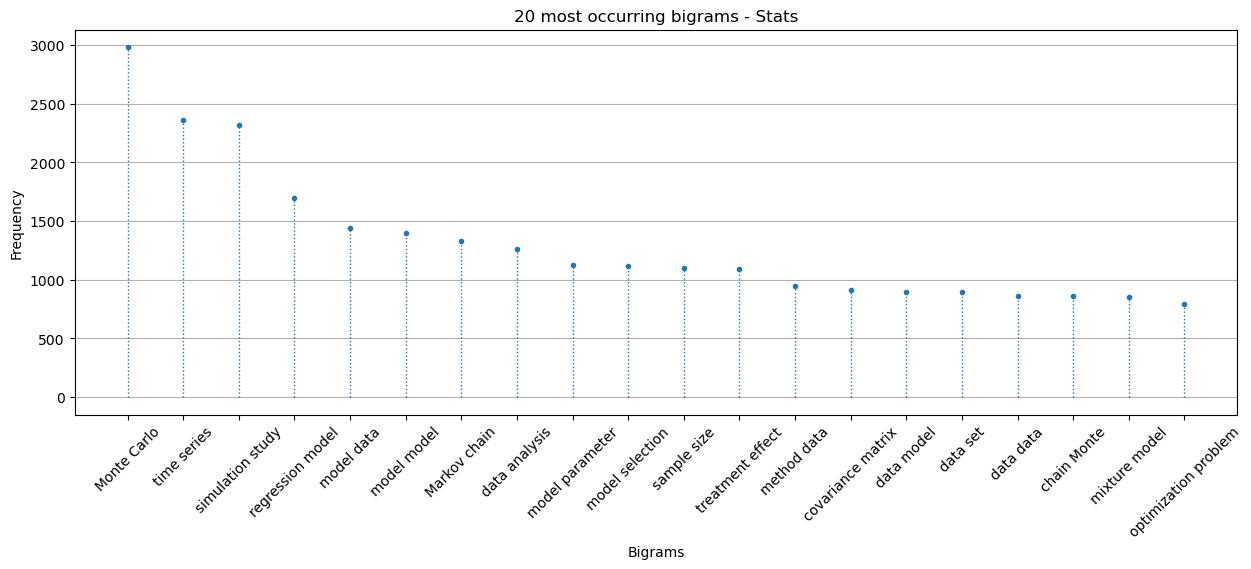

In [53]:
#plot the frequency cat 2
x, y = zip(*sort_grams2_list)

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(x, y, '.')
plt.xticks(rotation = 45)
ax.vlines(x, 0, y, lw=1, ls='dotted')
plt.title('20 most occurring bigrams - Stats'); plt.xlabel('Bigrams'); plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()

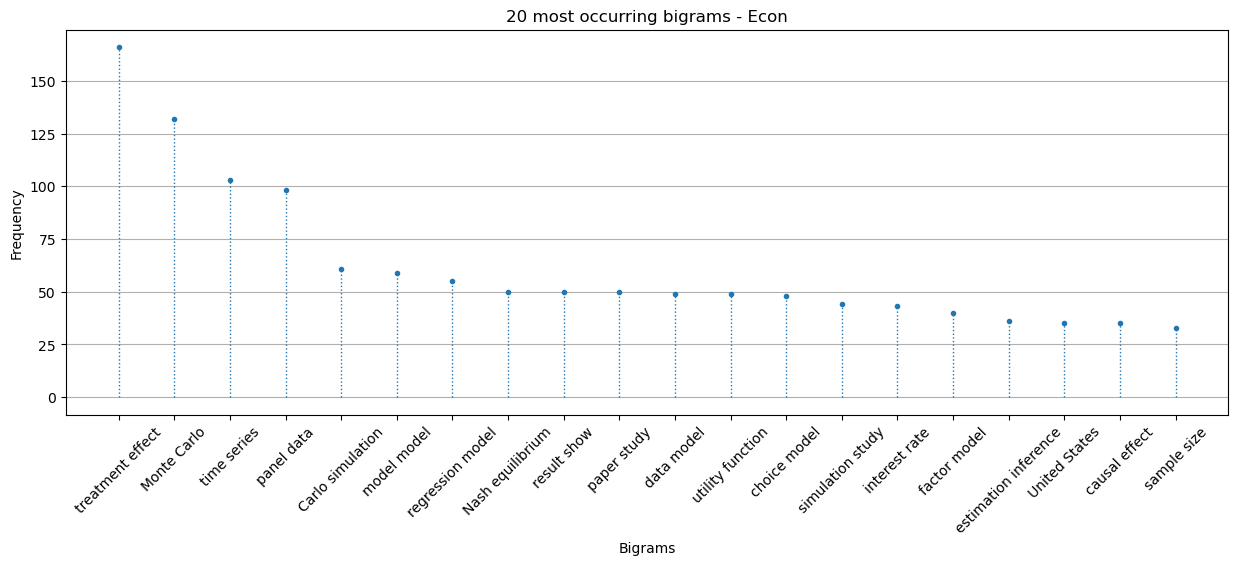

In [54]:
#plot the frequency cat 3
x, y = zip(*sort_grams3_list)

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(x, y, '.')
plt.xticks(rotation = 45)
ax.vlines(x, 0, y, lw=1, ls='dotted')
plt.title('20 most occurring bigrams - Econ'); plt.xlabel('Bigrams'); plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()

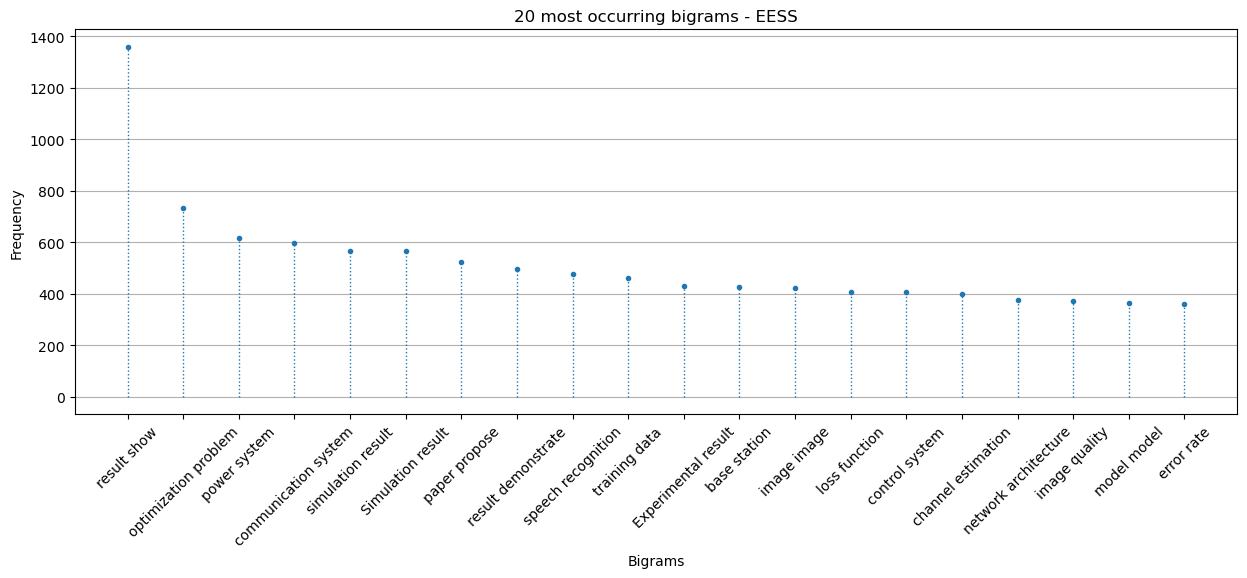

In [55]:
#plot the frequency cat 4
x, y = zip(*sort_grams4_list)

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(x, y, '.')
plt.xticks(rotation = 45)
ax.vlines(x, 0, y, lw=1, ls='dotted')
plt.title('20 most occurring bigrams - EESS'); plt.xlabel('Bigrams'); plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()